# Preparing

In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1HGDbDVoQXL50lJrrc4K77AOwmOF2b-Cc',
                                    dest_path='/content/data.json',
                                    unzip=True)

Unzipping...

/usr/local/lib/python3.7/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1HGDbDVoQXL50lJrrc4K77AOwmOF2b-Cc" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
!pip install transformers
!pip install torch
!pip install python-bidi
!pip -q install hazm
!pip -q install clean-text[gpl]
!pip install bs4
!pip install sklearn
!pip install collections
!pip install textwrap
!pip install pylab
!pip install matplotlib
!pip install seaborn
!pip install sentencepiece

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 32.5 MB/s 
     |████████████████████████████████| 596 kB 34.8 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 316 kB 5.5 MB/s 
     |████████████████████████████████| 1.4 MB 39.1 MB/s 
     |████████████████████████████████| 233 kB 42.2 MB/s 
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 170 kB 10.5 MB/s 
     |████████████████████████████████| 235 kB 38.0 MB/s 
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement textw

In [ ]:
import transformers
from transformers import AlbertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, AlbertTokenizer

import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
import json
file = open("data.json", encoding="utf8")
file = json.load(file)

In [ ]:
data = []
labels = ['منفی', 'خنثی', 'مثبت']
prev_sentence = []
for block in file:
  if len(block['Categories']) > 0:
    for i in range(len(block['Categories'])):
      if block['Categories'][i]['Sentence'] not in prev_sentence:
        data.append((block['Categories'][i]['Sentence'], labels[int(block['Categories'][i]['Sentiment']) + 1], block['Categories'][i]['Sentiment']+ 1))
      prev_sentence.append(block['Categories'][i]['Sentence'])

In [ ]:
df = pd.DataFrame(data, columns = ['sentence', 'sentiment', 'Labels'])
df = df[df.sentiment != 'خنثی']
df.Labels = df.Labels.replace({2:1})

,sentence,sentiment,Labels
0,واقعا عالی و ب موقع رسید.,مثبت,1
1,قیمتا خوب بود و سریع تحویل داده شد.,مثبت,1
2,واقعا سایت عالی سریع مرسوله میرسونن قیمت ها عا...,مثبت,1
3,سلام واقعیتش من یکبار خرید کردم که پرداخت در م...,مثبت,1
4,قیمت عالی ارسال رایگان برخورد فوق العاده خوب.,مثبت,1
...,...,...,...
3807,وبینار شش روزه در #ایسمینار برگزار کردیم عالی بود,مثبت,1
3808,از تیم ایسمینار راضی‌ام,مثبت,1
3809,پشتیبانی خوب,مثبت,1
3810,سایت خوب,مثبت,1


# data preprocessing

In [ ]:
import nltk
from hazm import Stemmer, Lemmatizer
from nltk import word_tokenize, sent_tokenize
# from PersianStemmer import PersianStemmer
from nltk.stem import WordNetLemmatizer
import string

from cleantext import clean
import codecs,re
def arabic_to_farsi(text):
    text = re.sub(r'[كﮑﮐﮏﮎﻜﻛﻚﻙ]', r'ک', text)
    text = re.sub(r'[ىىىﻴﻢﻳﻲﻱﻰىىﻯي]', r'ی', text)
    return text

def cleaning(text):
  text = str(text)
  text = re.sub(r'#', ' ', text)
  text = re.sub(r'_', ' ', text)
  text = text.replace('\u200c', ' ')
  text = re.sub(r'([ا-ی])\1{2,}', r'\1', text) # bbb+ -> b at least 2 char
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub(r'\@\w*', ' ', text)
  text = re.sub(r'\d+', ' ', text)
  text = re.sub(r'$', ' ', text)
  text = re.sub(r"[a-zA-Z0-9]+", " ",text)
  text = re.sub(r'<(.*?)>', ' ', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)
  text=re.sub(r'[۰۱۲۳۴۵۶۷۸۹٠١١٢٣٤٥٦٧٧٨٨٩٩●]',' ',text)
  text=re.sub(r'[\·\♦\٭\\,\^\|\˝\٬\’\”\‹\▪\○¼ç½éêüəıœ™Ááàäāćíłñū©ٰٔ]',' ',text)
  text=re.sub(r'[ًٌٍَُِّْ]',' ',text)
  text=re.sub(r'[]',r' ',text)
  text=re.sub(r'[\–\—…°≈≠±≤≥\−×÷√٪→←↔↑↓\#\٫]',u' ',text) 
  text=text.replace(u'•',u' ').replace(u'ˈ',u' ').replace(u'؛',u' ').replace(u'/',u' ').replace(u'ۀ',u'هٔ').replace(u"﴿",u' ').replace(u"﴾",u' ').replace(u"'",u' ').replace(u'\\',u' ').replace(u'[',u' ').replace(u']',u' ').replace(u'?',u' ').replace(u'؟',u' ').replace(u')',u' ').replace(u'_',u' ').replace(u'(u',u' ').replace(u'}',u' ').replace(u'{',u' ').replace(u'.',u' ').replace(u'>',u' ').replace(u'<',u' ')
  text=text.replace(u'`',u' ').replace(u'\t',u' ').replace(u'=',u' ').replace(u'»',u' ').replace(u'«',u' ').replace(u'~',u' ').replace(u'!',u' ').replace(u'@',u' ').replace(u'$',u' ').replace(u',u',u' ').replace(u'%',u' ').replace(u'،',u' ').replace(u'-',u' ').replace(u';',u' ').replace(u':',u' ').replace(u'*',u' ').replace(u'"',u' ').replace(u'&',u' ').replace(u'#',u' ').replace(u'+',u' ')
  text=re.sub(r'[\n\r]{2,}',u'\n',text)
  text = re.sub(u'(\u202A|\u202B|\u202C|\u202D|\u202E|\u200F|\uFEFF|\u2003|\¬|\­)',u'\u200C', text)#حذف کارکترهای تغییرجهت
  text = re.sub(u'‌{2,}', u'‌', text) # پشت‌سرهم
  text = re.sub(u'‌(?![ئاآأإژزرذدوؤةبپتثجچحخسشصضطظعغفقکگلمنهیيًٌٍَُِّْٰٓٔ]|[\u0900-\u097F]|ֹ)', u'', text) # در پس
  text = re.sub(u'(?<![ئبپتثجچحخسشصضطظعغفقکگلمنهیيًٌٍَُِّْٰٓٔ]|[\u0900-\u097F]|f|ֹ)‌', u'', text) # در پیش
  text=text.replace(u'­',u' ').replace(u'­',u' ').replace(u'ـ',u' ').replace(u'ـ',u' ').replace(u'ـ',u' ').replace(u'ـ',u' ').replace(u'',u' ')
  text=text.replace(u'',u' ')
  text = re.sub(u'‌{2,}', u'‌', text) # پشت‌سرهم
  text = re.sub(u'(\u00A0)',u' ', text).replace(u'(',u' ').replace(u')',u' ')
  text=text.replace(u'    ',u' ').replace(u'    ',u' ').replace(u'   ',u' ').replace(u'  ',u' ').replace(u'  ',u' ').replace(u'  ',u' ')
  # text=arabic_to_farsi(text)
  return text.strip()

def remove_stopwords(text):
  tokens = word_tokenize(text)
  persian_stopwords = StopWords

  results = [w for w in tokens if w not in persian_stopwords and w not in string.punctuation]
  
  return ' '.join(results)

def stemming(text):
  tokens = word_tokenize(text)
  persian_stemmer = Stemmer()

  results = [persian_stemmer.stem(w) for w in tokens]

  return ' '.join(results)

def lemmatizing(text):
  wordlist = []
  lemmatizer = WordNetLemmatizer()
  
  sentences = sent_tokenize(text)

  for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))

  return ' '.join(wordlist)

def normalize(text):
  # result = lemmatizing(text)
  result = stemming(text)
  result = remove_stopwords(result)

  return result


In [ ]:
df['cleaned'] = df.sentence.apply(cleaning)

In [ ]:
labels = ['منفی', 'خنثی', 'مثبت']

# Model

## perparing

In [ ]:
class_names = ['منفی' ,'مثبت']

In [ ]:
model_name = "m3hrdadfi/albert-fa-base-v2-sentiment-snappfood"
# model_name = "HooshvareLab/albert-fa-zwnj-base-v2"

In [ ]:
bert_model = AlbertModel.from_pretrained(model_name)
tokenizer = AlbertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/836 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2-sentiment-snappfood were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df.cleaned:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


307

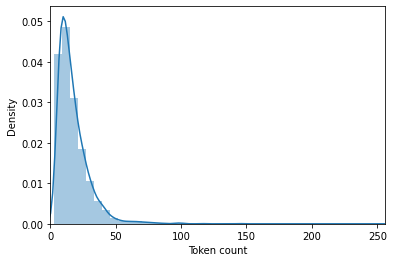

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
max(token_lens)

In [ ]:
RANDOM_SEED = 42
MAX_LEN = 120 # should be changed after determining the max length

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
class CommentDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.comments)
  
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = CommentDataset(
    comments=df.cleaned.to_numpy(),
    targets=df.Labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(model_name, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

Some weights of the model checkpoint at m3hrdadfi/albert-fa-base-v2-sentiment-snappfood were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1578, 0.3373, 0.5049],
        [0.2951, 0.4525, 0.2523],
        [0.2708, 0.3658, 0.3634],
        [0.3888, 0.3688, 0.2425],
        [0.3636, 0.4010, 0.2355],
        [0.3776, 0.3392, 0.2832],
        [0.2382, 0.3000, 0.4618],
        [0.2090, 0.2962, 0.4948],
        [0.2287, 0.4265, 0.3448],
        [0.1539, 0.5756, 0.2705],
        [0.1718, 0.5293, 0.2989],
        [0.2123, 0.3866, 0.4010],
        [0.2952, 0.3602, 0.3446],
        [0.3512, 0.3918, 0.2570],
        [0.2357, 0.5240, 0.2404],
        [0.3241, 0.3669, 0.3090],
        [0.2025, 0.4158, 0.3818],
        [0.3374, 0.4086, 0.2540],
        [0.2490, 0.4668, 0.2841],
        [0.2719, 0.3921, 0.3360],
        [0.1811, 0.4728, 0.3461],
        [0.3233, 0.2625, 0.4142],
        [0.2247, 0.3048, 0.4705],
        [0.1691, 0.5401, 0.2908],
        [0.3651, 0.4067, 0.2282],
        [0.1359, 0.4293, 0.4348],
        [0.3161, 0.2850, 0.3990],
        [0.1856, 0.4285, 0.3859],
        [0.2078, 0.4064, 0.3858],
        [0.218

## Train

In [ ]:
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=8e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  avg_loss = 0.0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

import time, sys


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print('-' * 10)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  print('-' * 10)

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )
  print('-' * 10)
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print('-' * 10)
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'sentiment_best_model_state.pt')
    best_accuracy = val_acc

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

----------
Train loss 0.25505967152239095 accuracy 0.901712111604312
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

----------
Val   loss 0.19396207109093666 accuracy 0.9085714285714286
----------

Epoch 2/2
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

----------
Train loss 0.08940548846272356 accuracy 0.9727330374128091
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

----------
Val   loss 0.24355719261802733 accuracy 0.92
----------

CPU times: user 4min 19s, sys: 1.13 s, total: 4min 21s
Wall time: 4min 22s


## Eval

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.9375

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

              precision    recall  f1-score   support

        منفی       0.89      0.91      0.90        53
        مثبت       0.96      0.95      0.96       123

    accuracy                           0.94       176
   macro avg       0.92      0.93      0.93       176
weighted avg       0.94      0.94      0.94       176



In [ ]:
torch.save(model, 'sentimentmbartV1.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/sentimentV1.pt /content/drive/MyDrive